# LangGraph with Claude API Demo

This notebook demonstrates a basic LangGraph application that interacts with the Claude API.

In [1]:
import os
from dotenv import load_dotenv
from agent import create_agent

# Load environment variables
load_dotenv()

# Configuration
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
MCP_SERVER_URL = "http://0.0.0.0:3000/mcp"
MODEL_ID = "claude-3-5-sonnet-20241022"  # Updated to use the latest model

# Create the agent with ToolsNode pattern
print("Creating Claude MCP Agent with ToolsNode pattern...")
agent = create_agent(ANTHROPIC_API_KEY, MCP_SERVER_URL, MODEL_ID)
print(f"Agent created with {len(agent.get_available_tools())} available tools")

Creating Claude MCP Agent with ToolsNode pattern...
Initialized with session ID: 501ace72-51ba-4789-87c2-e21f2f213837
Server info: {'name': 'restaurant-booking-server', 'version': '1.0.0'}
Available tools: ['search_restaurants', 'get_restaurant_details', 'get_booking_instructions', 'check_availability', 'make_reservation']
MCP session initialized successfully!
Available tools: ['search_restaurants', 'get_restaurant_details', 'get_booking_instructions', 'check_availability', 'make_reservation']
Created LangChain tool: search_restaurants
Created LangChain tool: get_restaurant_details
Created LangChain tool: get_booking_instructions
Created LangChain tool: check_availability
Created LangChain tool: make_reservation
Agent created with 5 available tools


# Test the fixed ToolsNode pattern with proper argument schemas
print("Testing Fixed ToolsNode Pattern...")

# Test 1: Simple restaurant search with required parameters
print("\n" + "="*60)
print("Test 1: Restaurant search with required parameters (mood and event)")
print("="*60)
response1 = agent.chat("Find me romantic Italian restaurants in Taipei for a date night.", "test_fixed")
print(f"Claude: {response1}")

# Test 2: Follow-up question using memory
print("\n" + "="*60)
print("Test 2: Follow-up question using conversation memory")
print("="*60)
response2 = agent.chat("What's the address of the first restaurant?", "test_fixed")
print(f"Claude: {response2}")

# Test 3: Show conversation history with proper message types
print("\n" + "="*60)
print("Test 3: Conversation history showing tool usage")
print("="*60)
agent.show_conversation_history("test_fixed")

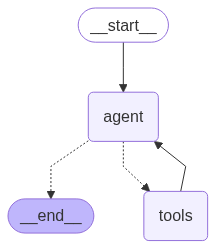

In [2]:
from IPython.display import Image, display

display(Image(agent.app.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Test the ToolsNode pattern with memory functionality
print("Testing ToolsNode pattern with memory...")

# Test 1: Restaurant search with automatic tool usage
print("\n" + "="*60)
print("Test 1: Restaurant search (should automatically use search_restaurants tool)")
print("="*60)
response1 = agent.chat("Find me romantic Italian restaurants in Taipei for tonight.")
print(f"Claude: {response1}")

Testing ToolsNode pattern with memory...

Test 1: Restaurant search (should automatically use search_restaurants tool)
Debug: Calling MCP tool search_restaurants with args: {'placeName': 'Taipei', 'cuisineTypes': ['Italian'], 'mood': 'romantic', 'event': 'dating'}
Claude: I've found several romantic Italian restaurants in Taipei that would be perfect for tonight. Here are the top recommendations:

1. Boungiorno J Ristorante
- Rating: 4.6/5 (424 reviews)
- Price Level: Moderate ($$)
- Address: Section 2, Anhe Rd, Da'an District
- Phone: 02 2737 4715

2. La Piola Cucina Italiana
- Rating: 4.5/5 (886 reviews)
- Price Level: Upscale ($$$)
- Address: Lane 308, Guangfu S Rd, Da'an District
- Phone: 02 2740 6638

3. Solo Pasta
- Rating: 4.5/5 (12,671 reviews)
- Price Level: Moderate ($$)
- Address: Section 1, Anhe Rd, Da'an District
- Phone: 02 2775 3645

All of these restaurants are currently open and accept reservations. Would you like me to check availability or get more detailed informati

In [4]:
# Test 2: Follow-up question that should use conversation memory
print("\n" + "="*60)
print("Test 2: Follow-up question (should remember previous search)")
print("="*60)
response2 = agent.chat("What are the opening hours for the second restaurant?")
print(f"Claude: {response2}")


Test 2: Follow-up question (should remember previous search)
Debug: Calling MCP tool get_restaurant_details with args: {'placeId': 'ChIJW2hXnsirQjQReAynJ_RDVsY'}
Claude: La Piola Cucina Italiana is currently open, but I notice that the detailed opening hours are not provided in the data. I recommend calling them directly at 02 2740 6638 to confirm their exact operating hours. The restaurant is reservable and currently open, but they require phone reservations rather than online booking.

Would you like me to help you get booking instructions or check availability for a specific time at this restaurant?


In [5]:
# Test 3: Tool usage with parameters
print("\n" + "="*60)
print("Test 3: Specific tool usage with detailed parameters")
print("="*60)
response3 = agent.chat("Search for casual Japanese restaurants near Ximending for a group of 4 people")
print(f"Claude: {response3}")


Test 3: Specific tool usage with detailed parameters
Debug: Calling MCP tool search_restaurants with args: {'placeName': 'Ximending', 'cuisineTypes': ['Japanese'], 'mood': 'casual', 'event': 'gathering'}
Claude: I've found several great casual Japanese restaurants near Ximending that would be perfect for a group of 4. Here are the top recommendations:

1. Nong Pu Japanese Cafe (農粹日式咖哩 西門店)
- Rating: 4.9/5 (1,536 reviews)
- Price Level: Moderate ($$)
- Address: Section 2, Kaifeng St, Wanhua District
- Phone: 02 2388 6940
- Currently open
- Very close to Ximending (258m)

2. Katsuya
- Rating: 4.7/5 (8,072 reviews)
- Price Level: Moderate ($$)
- Address: Zhongzheng District, 忠孝西路一段36號B1
- Phone: 02 2311 3318
- Currently open
- About 1km from Ximending

3. Dog Japanese Restaurant
- Rating: 4.6/5 (6,116 reviews)
- Price Level: Moderate ($$)
- Address: Xining Rd, Wanhua District
- Phone: 02 2311 9131
- Currently open
- Very close to Ximending (134m)
- Accepts reservations

All these restaur

In [6]:
# Test 4: Show conversation history with LangChain message format
print("\n" + "="*60)
print("Test 4: Conversation history (LangChain message format)")
print("="*60)
agent.show_conversation_history()


Test 4: Conversation history (LangChain message format)

Conversation History (Thread: default_conversation):
1. USER: Find me romantic Italian restaurants in Taipei for tonight.
2. ASSISTANT: [{'text': "I'll help you search for romantic Italian restaurants in Taipei for what sounds like a date night. Let me search using these criteria.", 'type': 'text'}, {'id': 'toolu_01611Kgt41pnNPjgs814T...
3. ToolMessage: content='{\n  "content": [\n    {\n      "type": "text",\n      "text": "{\\n  \\"searchCriteria\\": {\\n    \\"placeName\\": \\"Taipei\\",\\n    \\"cuisineTypes\\": [\\n      \\"Italian\\"\\n    ],\\...
4. ASSISTANT: I've found several romantic Italian restaurants in Taipei that would be perfect for tonight. Here are the top recommendations:

1. Boungiorno J Ristorante
- Rating: 4.6/5 (424 reviews)
- Price Level: ...
5. USER: What are the opening hours for the second restaurant?
6. ASSISTANT: [{'text': "I'll get the detailed information for La Piola Cucina Italiana.", 'type': 't

In [7]:
# Demonstrate the ToolsNode pattern capabilities
print("ToolsNode Pattern Capabilities:")
print("=" * 50)

# Show available tools
available_tools = agent.get_available_tools()
print(f"Available MCP Tools ({len(available_tools)}):")
for tool_name in available_tools:
    print(f"  - {tool_name}")

print("\nToolsNode Benefits:")
print("✓ Automatic tool routing based on LLM tool calls")
print("✓ Clean separation between agent logic and tool execution")
print("✓ Built-in tool result handling and formatting")
print("✓ Memory persistence across tool usage")
print("✓ LangChain ecosystem compatibility")

# Interactive chat
print(f"\n{'-'*50}")
print("Ready for interactive chat!")
print("Uncomment the line below to start:")
print("# agent.interactive_chat()")

# Or show demo
print("\nOr run the demo to see example use cases:")
agent.demo_tools()

ToolsNode Pattern Capabilities:
Available MCP Tools (5):
  - search_restaurants
  - get_restaurant_details
  - get_booking_instructions
  - check_availability
  - make_reservation

ToolsNode Benefits:
✓ Automatic tool routing based on LLM tool calls
✓ Clean separation between agent logic and tool execution
✓ Built-in tool result handling and formatting
✓ Memory persistence across tool usage
✓ LangChain ecosystem compatibility

--------------------------------------------------
Ready for interactive chat!
Uncomment the line below to start:
# agent.interactive_chat()

Or run the demo to see example use cases:
MCP Tools Demo with ToolsNode Pattern
Available MCP Tools:
- search_restaurants: Search for restaurants based on location, cuisine, keyword, mood, event, radius, price level, and locale
- get_restaurant_details: Get comprehensive details about a specific restaurant using its place ID
- get_booking_instructions: Get detailed instructions on how to make a reservation at a specific res

In [8]:
# Advanced testing utilities for ToolsNode pattern

def test_tool_workflow():
    """Test the complete tool workflow with detailed output"""
    print("Testing Tool Workflow Step-by-Step:")
    print("=" * 50)
    
    # Create a new thread for this test
    test_thread = "tool_workflow_test"
    
    print("1. User request with tool requirement...")
    user_query = "Search for upscale French restaurants in Taipei for a business dinner"
    print(f"   Query: {user_query}")
    
    response = agent.chat(user_query, test_thread)
    print(f"   Response: {response[:300]}...")
    
    print("\n2. Follow-up that should use memory...")
    followup = "What's the phone number for the first restaurant?"
    print(f"   Query: {followup}")
    
    response2 = agent.chat(followup, test_thread)
    print(f"   Response: {response2[:300]}...")
    
    print("\n3. Show conversation history for this test:")
    agent.show_conversation_history(test_thread)

def test_multiple_tools():
    """Test using multiple different tools in sequence"""
    print("\nTesting Multiple Tool Usage:")
    print("=" * 40)
    
    thread_id = "multi_tool_test"
    
    # Test each available tool
    test_queries = [
        "Find romantic restaurants in Taipei",
        "Get details for the first restaurant you found",
        "Check availability for tomorrow at 7 PM",
        "Help me make a reservation for 2 people"
    ]
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n{i}. {query}")
        response = agent.chat(query, thread_id)
        print(f"   → {response[:200]}...")

def test_no_tool_conversation():
    """Test regular conversation that doesn't require tools"""
    print("\nTesting Non-Tool Conversation:")
    print("=" * 35)
    
    thread_id = "no_tool_test"
    
    queries = [
        "What's the weather like today?",
        "Tell me a joke about restaurants",
        "What do you think about Taiwanese cuisine?"
    ]
    
    for query in queries:
        print(f"\nQ: {query}")
        response = agent.chat(query, thread_id)
        print(f"A: {response[:200]}...")

# Available test functions
print("Available Test Functions:")
print("- test_tool_workflow(): Complete tool workflow test")
print("- test_multiple_tools(): Test multiple tool usage")  
print("- test_no_tool_conversation(): Test non-tool conversations")
print("\nCall any of these functions to run specific tests!")
print("Example: test_tool_workflow()")

Available Test Functions:
- test_tool_workflow(): Complete tool workflow test
- test_multiple_tools(): Test multiple tool usage
- test_no_tool_conversation(): Test non-tool conversations

Call any of these functions to run specific tests!
Example: test_tool_workflow()
